In [1]:
#import all required packages
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = '../input/ncaaw-march-mania-2021/WDataFiles_Stage2/'

# Data preparation

In [3]:
df_seeds = pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")
df_seeds.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


In [4]:
df_season_results = pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [5]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [6]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1998,18,3104,91,3202,41,50
1,1998,18,3163,87,3221,76,11
2,1998,18,3222,66,3261,59,7
3,1998,18,3307,69,3365,62,7
4,1998,18,3349,115,3411,35,80


### Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

In [7]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [8]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [9]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [10]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

Merge

In [11]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [12]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [13]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [14]:
df_features_season.fillna(0, inplace=True)  

Compute features

In [15]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [16]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

In [17]:
df_features_season.head()

,Season,TeamID,WinRatio,GapAvg
0,1998,3102,0.166667,-20.625000
1,1998,3103,0.379310,-5.862069
2,1998,3104,0.700000,13.433333
3,1998,3106,0.285714,-7.952381
4,1998,3108,0.521739,1.304348


In [18]:
# df_tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
df_tourney_results = pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

The `DayNum` features can be improved by replacing it by the corresponding round.

In [19]:
def get_round(day):
#     round_dic = {134: 0, 135: 0, 136: 1, 137: 1, 138: 2, 139: 2, 143: 3, 144: 3, 145: 4, 146: 4, 152: 5, 154: 6}
    round_dic = {137: 0, 138: 0, 139: 1, 140: 1, 141: 2, 144: 3, 145: 3, 146: 4, 147: 4, 148: 4, 151:5, 153: 5, 155: 6} # probably wrong but I don't use it anyways
    try:
        return round_dic[day]
    except:
        print(f'Unknow day : {day}')
        return 0

In [20]:
df_tourney_results['Round'] = df_tourney_results['DayNum'].apply(get_round)

In [21]:
df_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round
0,1998,137,3104,94,3422,46,0
1,1998,137,3112,75,3365,63,0
2,1998,137,3163,93,3193,52,0
3,1998,137,3198,59,3266,45,0
4,1998,137,3203,74,3208,72,0


# Feature Engineering

## Train data

In [22]:
df = df_tourney_results.copy()

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round
0,1998,137,3104,94,3422,46,0
1,1998,137,3112,75,3365,63,0
2,1998,137,3163,93,3193,52,0
3,1998,137,3198,59,3266,45,0
4,1998,137,3203,74,3208,72,0


- Each row corresponds to a match between `WTeamID` and `LTeamID`, which was won by `WTeamID`. 
- I only keep matches after 2003 since I don't have the ratings for the older ones.
- I start by aggregating features coresponding to each tem.

### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [23]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [24]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [25]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [26]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [27]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round,SeedW,SeedL
0,1998,137,3104,94,3422,46,0,2,15
1,1998,137,3112,75,3365,63,0,3,14
2,1998,137,3163,93,3193,52,0,2,15
3,1998,137,3198,59,3266,45,0,7,10
4,1998,137,3203,74,3208,72,0,10,7


### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [28]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [29]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [30]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL
0,1998,137,3104,94,3422,46,0,2,15,0.700000,13.433333,0.703704,6.111111
1,1998,137,3112,75,3365,63,0,3,14,0.777778,12.407407,0.785714,17.821429
2,1998,137,3163,93,3193,52,0,2,15,0.937500,24.875000,0.714286,5.071429
3,1998,137,3198,59,3266,45,0,7,10,0.965517,25.103448,0.769231,9.538462
4,1998,137,3203,74,3208,72,0,10,7,0.653846,9.653846,0.653846,4.730769


### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [31]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
        "SeedW": "SeedA", 
        "SeedL": "SeedB",
        'WinRatioW' : 'WinRatioA',
        'WinRatioL' : 'WinRatioB',
        'GapAvgW' : 'GapAvgA',
        'GapAvgL' : 'GapAvgB'
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
        "SeedW": "SeedB", 
        "SeedL": "SeedA",
        'GapAvgW' : 'GapAvgB',
        'GapAvgL' : 'GapAvgA',
        'WinRatioW' : 'WinRatioB',
        'WinRatioL' : 'WinRatioA'
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [32]:
df = add_loosing_matches(df)

### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [33]:
df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinRatioDiff'] = df['WinRatioA'] - df['WinRatioB']
df['GapAvgDiff'] = df['GapAvgA'] - df['GapAvgB']

In [34]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
0,1998,137,3104,94,3422,46,0,2,15,0.700000,13.433333,0.703704,6.111111,-13,-0.003704,7.322222
1,1998,137,3112,75,3365,63,0,3,14,0.777778,12.407407,0.785714,17.821429,-11,-0.007937,-5.414021
2,1998,137,3163,93,3193,52,0,2,15,0.937500,24.875000,0.714286,5.071429,-13,0.223214,19.803571
3,1998,137,3198,59,3266,45,0,7,10,0.965517,25.103448,0.769231,9.538462,-3,0.196286,15.564987
4,1998,137,3203,74,3208,72,0,10,7,0.653846,9.653846,0.653846,4.730769,3,0.000000,4.923077


## Test Data

### Preparation

In [35]:
df_test = pd.read_csv(DATA_PATH + "WSampleSubmissionStage2.csv")

In [36]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [37]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2021_3104_3112,0.5,2021,3104,3112
1,2021_3104_3116,0.5,2021,3104,3116
2,2021_3104_3124,0.5,2021,3104,3124
3,2021_3104_3125,0.5,2021,3104,3125
4,2021_3104_3133,0.5,2021,3104,3133


### Seeds

In [38]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

In [39]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

In [40]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [41]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [42]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

### Differences

In [43]:
df_test['SeedDiff'] = df_test['SeedA'] - df_test['SeedB']
df_test['WinRatioDiff'] = df_test['WinRatioA'] - df_test['WinRatioB']
df_test['GapAvgDiff'] = df_test['GapAvgA'] - df_test['GapAvgB']

In [44]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
0,2021_3104_3112,0.5,2021,3104,3112,7,3,0.64,4.76,0.761905,10.523810,4,-0.121905,-5.763810
1,2021_3104_3116,0.5,2021,3104,3116,7,4,0.64,4.76,0.703704,9.000000,3,-0.063704,-4.240000
2,2021_3104_3124,0.5,2021,3104,3124,7,2,0.64,4.76,0.925926,27.111111,5,-0.285926,-22.351111
3,2021_3104_3125,0.5,2021,3104,3125,7,12,0.64,4.76,0.800000,12.320000,-5,-0.160000,-7.560000
4,2021_3104_3133,0.5,2021,3104,3133,7,11,0.64,4.76,0.592593,4.592593,-4,0.047407,0.167407


## Target

In [45]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

# Modeling

In [46]:
features = [
    'SeedA',
    'SeedB',
    'WinRatioA',
    'GapAvgA',
    'WinRatioB',
    'GapAvgB',
    'SeedDiff',
    'WinRatioDiff',
    'GapAvgDiff'
]

In [47]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

### Cross Validation
- Validate on season `n`, for `n` in the 10 last seasons.
- Train on earlier seasons 
- Pipeline support classification (predict the team that wins) and regression (predict the score gap)

In [48]:
def kfold_reg(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[10:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=10)
            
        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [49]:
df = df[df['Season'] <= 2019].reset_index(drop=True)
pred_tests = kfold_reg(df, df_test, plot=False, verbose=1, mode="cls")


Validating on season 2008
	 -> Scored 0.373

Validating on season 2009
	 -> Scored 0.467

Validating on season 2010
	 -> Scored 0.414

Validating on season 2011
	 -> Scored 0.391

Validating on season 2012
	 -> Scored 0.400

Validating on season 2013
	 -> Scored 0.442

Validating on season 2014
	 -> Scored 0.428

Validating on season 2015
	 -> Scored 0.375

Validating on season 2016
	 -> Scored 0.453

Validating on season 2017
	 -> Scored 0.444

Validating on season 2018
	 -> Scored 0.495

Validating on season 2019
	 -> Scored 0.388

 Local CV is 0.423


### Submission 
 
For the final submission, I am following the below strategy.

If the predicted probability by the model for team A winning is greater than 70% then the predicted values are used for submission else we make the probability of higher seed winning as 64% in one submission file and probability of lower seed winning as 64% in another submission file.


In [50]:
pred_tests = np.mean(pred_tests, 0)

In [51]:
pred_test1 = []
pred_test2 = []
for i in pred_tests:
    if i < 0.7 and i > 0.3:
        pred_test1.append(0.64)
        pred_test2.append(0.36)
    else:
        pred_test1.append(i)
        pred_test2.append(i)

In [52]:
sub1 = df_test[['ID', 'Pred']].copy()
sub1['Pred'] = pred_test1
sub1.to_csv('submission1.csv', index=False)

sub2 = df_test[['ID', 'Pred']].copy()
sub2['Pred'] = pred_test2
sub2.to_csv('submission2.csv', index=False)

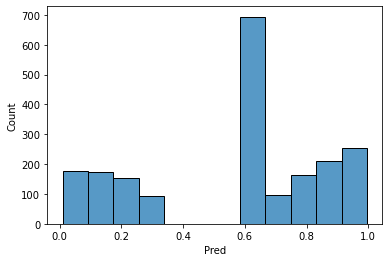

In [53]:
_ = sns.histplot(sub1['Pred'])

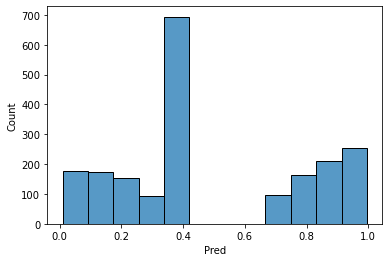

In [54]:
_ = sns.histplot(sub2['Pred'])

In [55]:
sub1.head()

,ID,Pred
0,2021_3104_3112,0.235174
1,2021_3104_3116,0.281256
2,2021_3104_3124,0.068013
3,2021_3104_3125,0.640000
4,2021_3104_3133,0.640000
